In [1]:
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely.geometry
import matplotlib.pyplot as plt
import re
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde

# dfのcellの内容をすべて表示
# pd.options.display.max_colwidth=10000

In [2]:
# 緯度経度の座標系
src_epsg = 4326
# メートルの座標系
dst_epsg = 26971

# csvの緯度経度からmの座標系に変換
# x:Longitude(経度)
# y:Latitude(緯度)

def LatiLongi_to_meter(df, longitude, latitude):
    # 緯度経度をgeometryに
    new_geometry = gpd.points_from_xy(x=longitude, y=latitude)
    # gdfの作成
    df = gpd.GeoDataFrame(df, geometry=new_geometry).set_crs(f'EPSG:{src_epsg}', allow_override=True)
    # EPSGを変換
    df.to_crs(epsg=dst_epsg, inplace=True)

    return df

In [3]:
# grid内の特徴点の個数をカウントする
def count_features(gdf_grid, gdf_feature):
    # gdfのgeometryを抽出
    grid_geom = gdf_grid.geometry
    gdf_feature_points_geom = gdf_feature.geometry 

    # grid内に特徴点の個数をカウント
    # https://note.com/bright_moraea170/n/nbb8653fa3a1e
    mask = gdf_feature_points_geom.within(grid_geom)
    cnt = len(gdf_feature_points_geom[mask])

    return cnt

# Grid Mapの作成

len(gdf_chicago):2593


<Axes: >

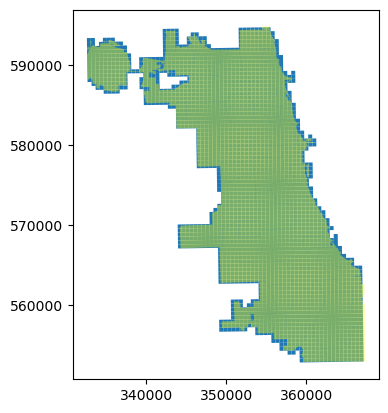

In [4]:
gdf_chicago = gpd.read_file('/root/workdir/data/RTM/gdf/chicago.geojson').to_crs(epsg=26971)
gdf_chicago = gdf_chicago[['geometry']]
# number of meters
STEP = 500

a, b, c, d = gdf_chicago.to_crs(gdf_chicago.estimate_utm_crs()).total_bounds

# create a grid for chicago
gdf_grid = gpd.GeoDataFrame(
    geometry=[
        shapely.geometry.box(minx, miny, maxx, maxy)
        for minx, maxx in zip(np.arange(a, c, STEP), np.arange(a, c, STEP)[1:])
        for miny, maxy in zip(np.arange(b, d, STEP), np.arange(b, d, STEP)[1:])
    ],
    crs=gdf_chicago.estimate_utm_crs(),

).to_crs(gdf_chicago.crs)

# restrict grid to only squares that intersect with chicago geometry
gdf_grid = (
    gdf_grid.sjoin(gdf_chicago)

    .pipe(lambda d: d.groupby(d.index).first())
    .set_crs(gdf_grid.crs)
    .drop(columns=["index_right"])
)
gdf_grid.reset_index(drop=True, inplace=True)
print(f"len(gdf_chicago):{len(gdf_grid)}")
ax =gdf_grid.plot()
gdf_chicago.plot(ax=ax, alpha=0.4,color='yellow')

# 特徴量の生成
#### 1.特徴点とグリッドの重心との間の距離を測る
#### 2.特徴点のKDEを計算

In [85]:

# gridの中心のxy座標を取得
gdf_grid['centroid_x'] = gdf_grid.geometry.centroid.x
gdf_grid['centroid_y'] = gdf_grid.geometry.centroid.y
# KDEが学習できるように整形
centroid_data = np.vstack([np.array(gdf_grid['centroid_x']), np.array(gdf_grid['centroid_y'])])

# sklearn.NearestNeighborを使って最近傍点との距離を求める
def get_distance(gdf_grid,gdf_feature):
    #gdfのgeometryを抽出してnp.arrayに変換
    grid_center= gdf_grid.geometry.centroid
    X = np.stack([gdf_feature.geometry.x,gdf_feature.geometry.y], axis=1)
    test_data = np.array([grid_center.x,grid_center.y]).reshape(1,-1)

    #grid_centerから近傍の特徴点を求める
    # instance
    extractor = NearestNeighbors(metric='euclidean', n_neighbors=1, n_jobs=-1)
    # fit
    extractor.fit(X)
    distance, index = extractor.kneighbors(test_data)
    
    return distance[0][0]


def create_feature(gdf_grid, gdf_feature, feature_name):
    # 距離の計算
    gdf_grid[f'{feature_name}_distance'] = gdf_grid.apply(get_distance, gdf_feature=gdf_feature, axis=1)
    # ある範囲内(m)に特徴点があるか判定
    for threshold in [271 ,519, 779, 999]:
        gdf_grid[f'{feature_name}_{threshold}_DST'] = gdf_grid[f'{feature_name}_distance'].apply(lambda x: 1 if x<=threshold else 0)
    # ditanceを削除
    gdf_grid.drop(f'{feature_name}_distance', axis=1, inplace=True)
    
    # KDEの計算
    # ある特徴点を学習
    data = np.array([gdf_feature.geometry.x,gdf_feature.geometry.y])
    # 4つのバンド幅でKDEを計算
    for threshhold in [271 ,519, 779, 999]:   
        kde = gaussian_kde(data, bw_method=threshhold/(10**3))
        gdf_grid[f'{feature_name}_{threshhold}_density'] = kde.evaluate(centroid_data)
        # しきい値でダミー変数化
        KDE_threshold = np.mean(gdf_grid[f'{feature_name}_{threshhold}_density']) + 2*np.std(gdf_grid[f'{feature_name}_{threshhold}_density'])
        gdf_grid[f'{feature_name}_{threshhold}_KDE'] = gdf_grid[f'{feature_name}_{threshhold}_density'].apply(lambda x: 1 if x>=KDE_threshold else 0)
        gdf_grid.drop(f'{feature_name}_{threshhold}_density', axis=1, inplace=True)

# 目標変数：強盗件数データの読み込み

In [5]:
# データ準備
gdf_crime = pd.read_csv('https://data.cityofchicago.org/resource/ijzp-q8t2.csv?$limit=8181463')
# 緯度経度のNaNをdrop
gdf_crime.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_crime.drop(gdf_crime.index[(gdf_crime['latitude'] == 0) | (gdf_crime['longitude'] == 0)], inplace=True)
gdf_crime = LatiLongi_to_meter(gdf_crime, longitude=gdf_crime['longitude'], latitude=gdf_crime['latitude'])
# gdf_crime.to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_crime.geojson', driver="GeoJSON")

In [86]:
# 強盗のみを抽出
gdf_BURGLARY = gdf_crime[gdf_crime['primary_type']=='BURGLARY']
gdf_BURGLARY['date'] = pd.to_datetime(gdf_BURGLARY['date'])
# gdf_BURGLARY = LatiLongi_to_meter(gdf_BURGLARY, longitude=gdf_BURGLARY['longitude'], latitude=gdf_BURGLARY['latitude'])
# 2010~2023年の強盗データを抽出
for i in range(2010,2024):
    # gdf_BURGLARY[gdf_BURGLARY['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_BURGLARY_{i}.geojson', driver="GeoJSON")
    gdf_grid[f'crime_cnt_{i}'] = gdf_grid.apply(count_features, gdf_feature=gdf_BURGLARY[gdf_BURGLARY['date'].dt.year == i], axis=1)
# 2010~2023までの強盗件数をカウントしたグリッドを書き出す
gdf_grid.to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_grid_{STEP}.geojson', driver="GeoJSON")

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# 特徴変数データの読み込み

### <注意>
### latitude, longitude = (0,0)だと,geometryがPOINT (Infinity Infinity)になってしまうのでdropする必要あり

# VAB:Vacant and Abandoned Buildings - Violations

In [65]:
gdf_VAB = pd.read_csv('https://data.cityofchicago.org/resource/7nii-7srd.csv?$limit=65119')
# 緯度経度のNaNをdrop
gdf_VAB.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_VAB.drop(gdf_VAB.index[(gdf_VAB['latitude'] == 0) | (gdf_VAB['longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_VAB = LatiLongi_to_meter(gdf_VAB, longitude=gdf_VAB['longitude'], latitude=gdf_VAB['latitude'])
gdf_VAB['date'] = pd.to_datetime(gdf_VAB['date_service_request_was_received'])
for i in range(2008,2019):
    gdf_VAB[gdf_VAB['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_VAB_{i}.geojson', driver="GeoJSON")

# SLO:Street_Lights_One_Out

In [77]:
gdf_SLO = pd.read_csv('https://data.cityofchicago.org/resource/3aav-uy2v.csv?$limit=486817')
# 緯度経度のNaNをdrop
gdf_SLO.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_SLO.drop(gdf_SLO.index[(gdf_SLO['latitude'] == 0) | (gdf_SLO['longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_SLO = LatiLongi_to_meter(gdf_SLO, longitude=gdf_SLO['longitude'], latitude=gdf_SLO['latitude'])
gdf_SLO['date'] = pd.to_datetime(gdf_SLO['completion_date'])
for i in range(2011,2019):
    gdf_SLO[gdf_SLO['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_SLO_{i}.geojson', driver="GeoJSON")

# School

In [23]:
for i in range(2010,2021):    
    gdf_School = pd.read_csv(f'/root/workdir/selfRTM/School{i}.csv')
    if 2015<=i<=2017 or i==2020  :
        # 緯度経度のNaNをdrop
        gdf_School.dropna(subset=['Long', 'Lat'], inplace=True)
        gdf_School.drop(gdf_School.index[(gdf_School['Long'] == 0) | (gdf_School['Lat'] == 0)], inplace=True)
        # # 緯度経度をmerterに変換
        gdf_School = LatiLongi_to_meter(gdf_School, longitude=gdf_School['Long'], latitude=gdf_School['Lat'])
    elif i==2018:
        gdf_School[['Long', 'Lat']] = gdf_School['the_geom'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)')
        # 緯度経度のNaNをdrop
        gdf_School.dropna(subset=['Long', 'Lat'], inplace=True)
        gdf_School.drop(gdf_School.index[(gdf_School['Long'] == 0) | (gdf_School['Lat'] == 0)], inplace=True)
        # # 緯度経度をmerterに変換
        gdf_School = LatiLongi_to_meter(gdf_School, longitude=gdf_School['Long'], latitude=gdf_School['Lat'])
    else:
        # 緯度経度のNaNをdrop
        gdf_School.dropna(subset=['X', 'Y'], inplace=True)
        gdf_School.drop(gdf_School.index[(gdf_School['X'] == 0) | (gdf_School['Y'] == 0)], inplace=True)
        # # 緯度経度をmerterに変換
        gdf_School = LatiLongi_to_meter(gdf_School, longitude=gdf_School['X'], latitude=gdf_School['Y'])

    gdf_School[['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_School_{i}.geojson', driver="GeoJSON")

# Sanitation

In [143]:
gdf_Sanitation = pd.read_csv('https://data.cityofchicago.org/resource/me59-5fac.csv?$limit=152664')
# 緯度経度のNaNをdrop
gdf_Sanitation.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_Sanitation.drop(gdf_Sanitation.index[(gdf_Sanitation['latitude'] == 0) | (gdf_Sanitation['longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_Sanitation = LatiLongi_to_meter(gdf_Sanitation, longitude=gdf_Sanitation['longitude'], latitude=gdf_Sanitation['latitude'])
gdf_Sanitation['date'] = pd.to_datetime(gdf_Sanitation['creation_date'])
for i in range(2011,2019):
    gdf_Sanitation[gdf_Sanitation['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_Sanitation_{i}.geojson', driver="GeoJSON")

# Graffiti removal

In [19]:
gdf_Graffiti = pd.read_csv('/root/workdir/selfRTM/Graffiti_Removal.csv')
# 緯度経度のNaNをdrop
gdf_Graffiti.dropna(subset=['Latitude', 'Longitude'], inplace=True)
# 緯度経度が0,0の行をdrop
gdf_Graffiti.drop(gdf_Graffiti.index[(gdf_Graffiti['Latitude'] == 0) | (gdf_Graffiti['Longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_Graffiti = LatiLongi_to_meter(gdf_Graffiti, longitude=gdf_Graffiti['Longitude'], latitude=gdf_Graffiti['Latitude'])
gdf_Graffiti['date'] = pd.to_datetime(gdf_Graffiti['Creation Date'])
for i in range(2011,2019):
    gdf_Graffiti[gdf_Graffiti['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_Graffiti_{i}.geojson', driver="GeoJSON")

# Foreclosure

In [37]:
for i in range(2011,2013):
    if i==2011:
        gdf_Foreclosure = pd.read_csv('https://datacatalog.cookcountyil.gov/resource/epxa-9ihc.csv?$limit=47069')
        location = 'location_1'
    elif i==2012:
        gdf_Foreclosure = pd.read_csv('https://datacatalog.cookcountyil.gov/resource/9br9-dhca.csv?$limit=45400')
        location = 'location_1'
    else:
        break
    # 緯度経度のNaNをdrop
    gdf_Foreclosure.dropna(subset=[location], inplace=True)

    gdf_Foreclosure['Latitude'] = np.nan
    gdf_Foreclosure['Longitude'] = np.nan

    # 正規表現パターン
    pattern = r'\(([-+]?\d+\.\d+),\s*([-+]?\d+\.\d+)\)'

    for index, row in gdf_Foreclosure.iterrows():
        text = row[location]
        # マッチを探す
        match = re.search(pattern, text)
        if match:
            gdf_Foreclosure.at[index, 'Latitude'] = match.group(1)
            gdf_Foreclosure.at[index, 'Longitude'] = match.group(2)
            
    gdf_Foreclosure.drop(gdf_Foreclosure.index[(gdf_Foreclosure['Latitude'] == 0) | (gdf_Foreclosure['Longitude'] == 0)], inplace=True)
    # 緯度経度をmerterに変換
    gdf_Foreclosure = LatiLongi_to_meter(gdf_Foreclosure, longitude=gdf_Foreclosure['Longitude'], latitude=gdf_Foreclosure['Latitude'])

    # chicago の grid上にあるpointだけを抽出
    # 削除したい行のインデックスを収集するリスト
    rows_to_drop = []

    for index, row in gdf_Foreclosure.iterrows():
        if True not in list(row.geometry.within(gdf_grid.geometry)):
            rows_to_drop.append(index)
    # インデックスを使って行を削除
    gdf_Foreclosure = gdf_Foreclosure.drop(rows_to_drop)
    gdf_Foreclosure['date'] = pd.to_datetime(gdf_Foreclosure['recorded_date'])
    gdf_Foreclosure[gdf_Foreclosure['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_Foreclosure_{i}.geojson', driver="GeoJSON")


/tmp/ipykernel_611/2773190235.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '41.8745676084568' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf_Foreclosure.at[index, 'Latitude'] = match.group(1)
/tmp/ipykernel_611/2773190235.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-87.80084316240078' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf_Foreclosure.at[index, 'Longitude'] = match.group(2)
/tmp/ipykernel_611/2773190235.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '41.61341348436838' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf_Foreclosure.at[index, 'Latitude'] = match.group(1)
/tmp/ipykernel_611/2773190235.py:25: Fu

In [47]:
# 2013,2014
gdf_Foreclosure = pd.read_csv('https://datacatalog.cookcountyil.gov/resource/nk2q-7kjv.csv?$limit=51950')
location = 'Location'

# 緯度経度のNaNをdrop
gdf_Foreclosure.dropna(subset=[location], inplace=True)

gdf_Foreclosure['Latitude'] = np.nan
gdf_Foreclosure['Longitude'] = np.nan

# 正規表現パターン
pattern = r'\(([-+]?\d+\.\d+),\s*([-+]?\d+\.\d+)\)'

for index, row in gdf_Foreclosure.iterrows():
    text = row[location]
    # マッチを探す
    match = re.search(pattern, text)
    if match:
        gdf_Foreclosure.at[index, 'Latitude'] = match.group(1)
        gdf_Foreclosure.at[index, 'Longitude'] = match.group(2)
        
gdf_Foreclosure.drop(gdf_Foreclosure.index[(gdf_Foreclosure['Latitude'] == 0) | (gdf_Foreclosure['Longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_Foreclosure = LatiLongi_to_meter(gdf_Foreclosure, longitude=gdf_Foreclosure['Longitude'], latitude=gdf_Foreclosure['Latitude'])

# chicago の grid上にあるpointだけを抽出
# 削除したい行のインデックスを収集するリスト
rows_to_drop = []

for index, row in gdf_Foreclosure.iterrows():
    if True not in list(row.geometry.within(gdf_grid.geometry)):
        rows_to_drop.append(index)
# インデックスを使って行を削除
gdf_Foreclosure = gdf_Foreclosure.drop(rows_to_drop)
gdf_Foreclosure['date'] = pd.to_datetime(gdf_Foreclosure['Recorded Date'])
for i in range(2013,2015):
    gdf_Foreclosure[gdf_Foreclosure['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_Foreclosure_{i}.geojson', driver="GeoJSON")

/tmp/ipykernel_611/1228886522.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '42.08563190500007' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf_Foreclosure.at[index, 'Latitude'] = match.group(1)
/tmp/ipykernel_611/1228886522.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-88.03927053899997' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf_Foreclosure.at[index, 'Longitude'] = match.group(2)


# Alley Light Out

In [63]:
gdf_Alley = pd.read_csv('https://data.cityofchicago.org/resource/t28b-ys7j.csv?$limit=219010')
# 緯度経度のNaNをdrop
gdf_Alley.dropna(subset=['latitude', 'longitude'], inplace=True)
gdf_Alley.drop(gdf_Alley.index[(gdf_Alley['latitude'] == 0) | (gdf_Alley['longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_Alley = LatiLongi_to_meter(gdf_Alley, longitude=gdf_Alley['longitude'], latitude=gdf_Alley['latitude'])
gdf_Alley['date'] = pd.to_datetime(gdf_Alley['creation_date'])
for i in range(2011,2019):
    gdf_Alley[gdf_Alley['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_Alley_{i}.geojson', driver="GeoJSON")

# Abandoned Vehicles

In [79]:
gdf_Vehicles = pd.read_csv('https://data.cityofchicago.org/resource/atid-bgws.csv?$limit=207858')
# 緯度経度のNaNをdrop
gdf_Vehicles.dropna(subset=['Latitude', 'Longitude'], inplace=True)
gdf_Vehicles.drop(gdf_Vehicles.index[(gdf_Vehicles['Latitude'] == 0) | (gdf_Vehicles['Longitude'] == 0)], inplace=True)
# 緯度経度をmerterに変換
gdf_Vehicles = LatiLongi_to_meter(gdf_Vehicles, longitude=gdf_Vehicles['Longitude'], latitude=gdf_Vehicles['Latitude'])
gdf_Vehicles['date'] = pd.to_datetime(gdf_Vehicles['Creation Date'])
for i in range(2011,2021):
    gdf_Vehicles[gdf_Vehicles['date'].dt.year == i][['geometry']].to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_Vehicles_{i}.geojson', driver="GeoJSON")

In [5]:
gdf_Vehicles = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Vehicles_2011.geojson')

# 2014年度の各特徴量を図示

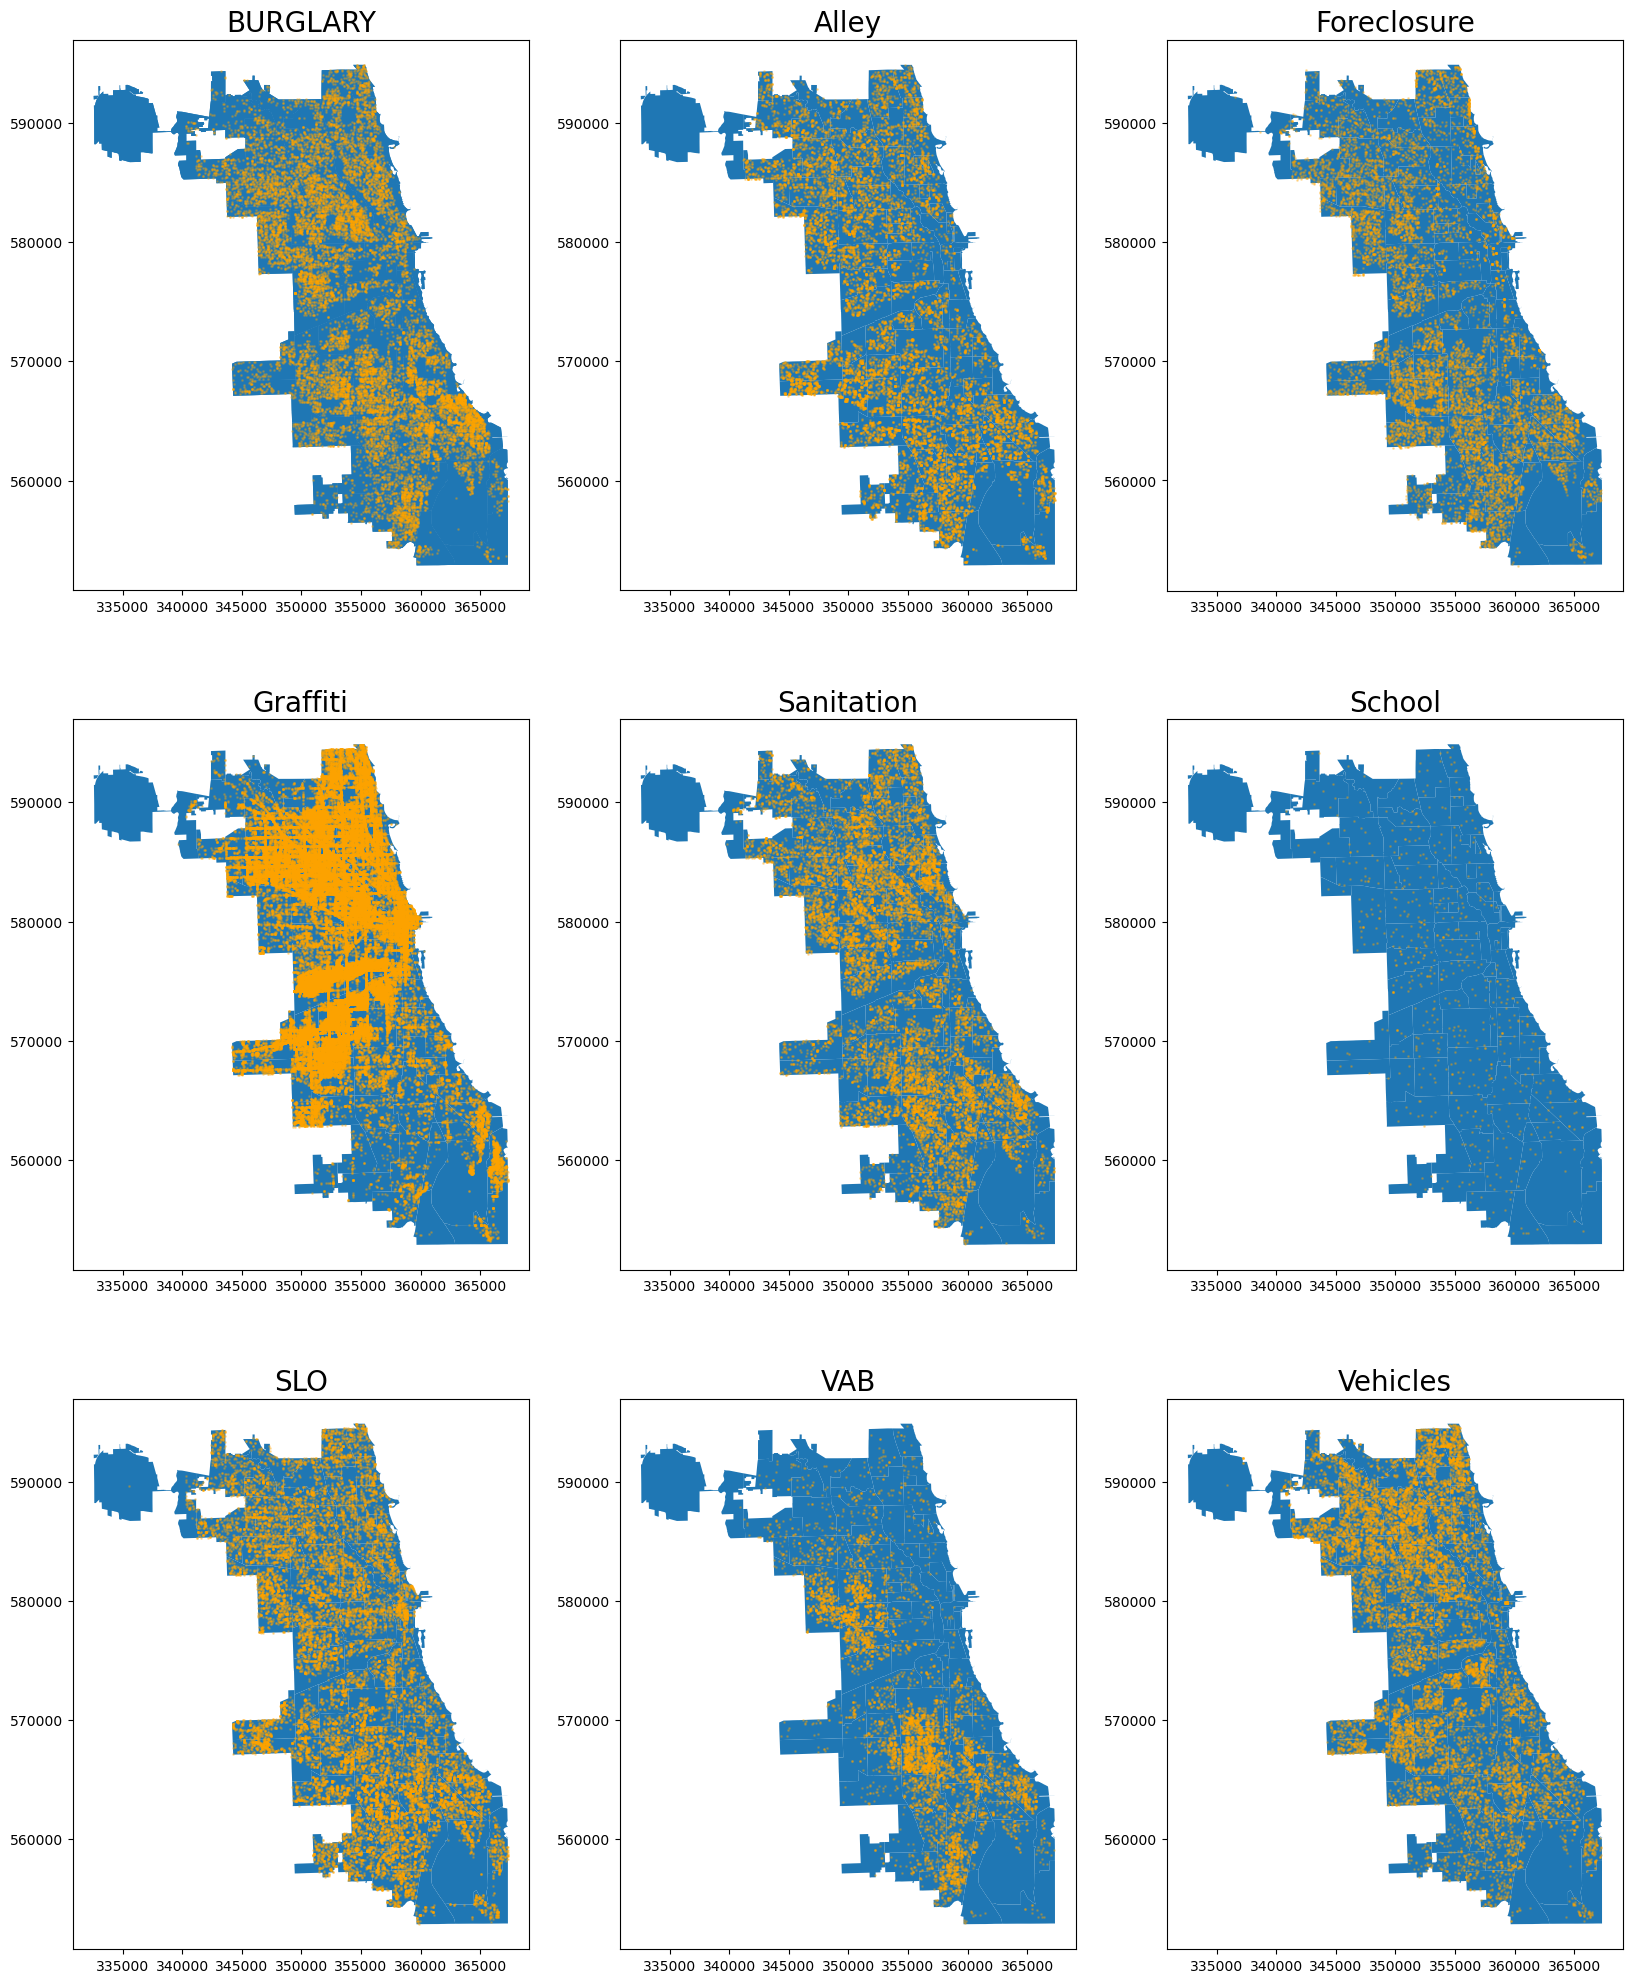

In [ ]:
gdf_feature_list = ['BURGLARY', 'Alley', 'Foreclosure', 'Graffiti', 'Sanitation', 'School', 'SLO', 'VAB', 'Vehicles']
fig, axes = plt.subplots(3,3, figsize=(20,25))
gdf_chicago.plot(ax=axes[0,0])

for feature, ax in zip(gdf_feature_list, axes.ravel()):
    gdf = gpd.read_file(f'/root/workdir/data/RTM/gdf/gdf_{feature}_2013.geojson')
    gdf_chicago.plot(ax=ax)
    gdf.plot(ax=ax,markersize=1, alpha=0.3, color='orange')
    ax.set_title(feature, fontsize=20)

# gdf_gridに特徴量を追加

### 2011~2013で学習,2014でテスト

In [17]:
gdf_grid['crime_cnt_2011_13'] = gdf_grid['crime_cnt_2011'] + gdf_grid['crime_cnt_2012'] + gdf_grid['crime_cnt_2013']

### 3年間の入力データをまとめる

In [40]:
gdf_BURGLARY_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_BURGLARY_2011.geojson')
gdf_BURGLARY_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_BURGLARY_2012.geojson')
gdf_BURGLARY_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_BURGLARY_2013.geojson')
gdf_BURGLARY_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_BURGLARY_2014.geojson')
gdf_BURGLARY_2011_13 = pd.concat([gdf_BURGLARY_2011, gdf_BURGLARY_2012, gdf_BURGLARY_2013], ignore_index=True)

In [58]:
gdf_Alley_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Alley_2011.geojson')
gdf_Alley_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Alley_2012.geojson')
gdf_Alley_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Alley_2013.geojson')
gdf_Alley_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Alley_2011.geojson')
gdf_Alley_2011_13 = pd.concat([gdf_Alley_2011, gdf_Alley_2012, gdf_Alley_2013], ignore_index=True)


In [42]:
gdf_Foreclosure_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Foreclosure_2011.geojson')
gdf_Foreclosure_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Foreclosure_2012.geojson')
gdf_Foreclosure_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Foreclosure_2013.geojson')
gdf_Foreclosure_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Foreclosure_2014.geojson')
gdf_Foreclosure_2011_13 = pd.concat([gdf_Foreclosure_2011, gdf_Foreclosure_2012, gdf_Foreclosure_2013], ignore_index=True)


In [43]:
gdf_Graffiti_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Graffiti_2011.geojson')
gdf_Graffiti_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Graffiti_2012.geojson')
gdf_Graffiti_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Graffiti_2013.geojson')
gdf_Graffiti_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Graffiti_2014.geojson')
gdf_Graffiti_2011_13 = pd.concat([gdf_Graffiti_2011, gdf_Graffiti_2012, gdf_Graffiti_2013], ignore_index=True)


In [44]:
gdf_Sanitation_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Sanitation_2011.geojson')
gdf_Sanitation_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Sanitation_2012.geojson')
gdf_Sanitation_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Sanitation_2013.geojson')
gdf_Sanitation_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Sanitation_2014.geojson')
gdf_Sanitation_2011_13 = pd.concat([gdf_Sanitation_2011, gdf_Sanitation_2012, gdf_Sanitation_2013], ignore_index=True)


In [45]:
gdf_School_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_School_2011.geojson')
gdf_School_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_School_2012.geojson')
gdf_School_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_School_2013.geojson')
gdf_School_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_School_2014.geojson')
gdf_School_2011_13 = pd.concat([gdf_School_2011, gdf_School_2012, gdf_School_2013], ignore_index=True)


In [46]:
gdf_SLO_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_SLO_2011.geojson')
gdf_SLO_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_SLO_2012.geojson')
gdf_SLO_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_SLO_2013.geojson')
gdf_SLO_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_SLO_2014.geojson')
gdf_SLO_2011_13 = pd.concat([gdf_SLO_2011, gdf_SLO_2012, gdf_SLO_2013], ignore_index=True)


In [47]:
gdf_VAB_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_VAB_2011.geojson')
gdf_VAB_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_VAB_2012.geojson')
gdf_VAB_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_VAB_2013.geojson')
gdf_VAB_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_VAB_2014.geojson')
gdf_VAB_2011_13 = pd.concat([gdf_VAB_2011, gdf_VAB_2012, gdf_VAB_2013], ignore_index=True)


In [48]:
gdf_Vehicles_2011 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Vehicles_2011.geojson')
gdf_Vehicles_2012 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Vehicles_2012.geojson')
gdf_Vehicles_2013 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Vehicles_2013.geojson')
gdf_Vehicles_2014 = gpd.read_file('/root/workdir/data/RTM/gdf/gdf_Vehicles_2014.geojson')
gdf_Vehicles_2011_13 = pd.concat([gdf_Vehicles_2011, gdf_Vehicles_2012, gdf_Vehicles_2013], ignore_index=True)


# X_train

In [90]:
create_feature(gdf_grid, gdf_feature=gdf_Alley_2011_13, feature_name='Alley')
create_feature(gdf_grid, gdf_feature=gdf_Foreclosure_2011_13, feature_name='Foreclosure')
create_feature(gdf_grid, gdf_feature=gdf_Graffiti_2011_13, feature_name='Graffiti')
create_feature(gdf_grid, gdf_feature=gdf_Sanitation_2011_13, feature_name='Sanitation')
create_feature(gdf_grid, gdf_feature=gdf_School_2011_13, feature_name='School')
create_feature(gdf_grid, gdf_feature=gdf_SLO_2011_13, feature_name='SLO')
create_feature(gdf_grid, gdf_feature=gdf_VAB_2011_13, feature_name='VAB')
create_feature(gdf_grid, gdf_feature=gdf_Vehicles_2011_13, feature_name='Vehicles')
# X_train
gdf_grid.to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_grid_{STEP}_2011_13.geojson', driver="GeoJSON")

# X_test

In [91]:
gdf_grid = gpd.read_file(f'/root/workdir/data/RTM/gdf/gdf_grid_{STEP}.geojson')

In [92]:
create_feature(gdf_grid, gdf_feature=gdf_Alley_2014, feature_name='Alley')
create_feature(gdf_grid, gdf_feature=gdf_Foreclosure_2014, feature_name='Foreclosure')
create_feature(gdf_grid, gdf_feature=gdf_Graffiti_2014, feature_name='Graffiti')
create_feature(gdf_grid, gdf_feature=gdf_Sanitation_2014, feature_name='Sanitation')
create_feature(gdf_grid, gdf_feature=gdf_School_2014, feature_name='School')
create_feature(gdf_grid, gdf_feature=gdf_SLO_2014, feature_name='SLO')
create_feature(gdf_grid, gdf_feature=gdf_VAB_2014, feature_name='VAB')
create_feature(gdf_grid, gdf_feature=gdf_Vehicles_2014, feature_name='Vehicles')

In [93]:
# X_test
gdf_grid.to_file(filename=f'/root/workdir/data/RTM/gdf/gdf_grid_{STEP}_2014_test.geojson', driver="GeoJSON")